In [39]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches, colors, cm

# File names
datafile = 'dr17_cut_data.csv'
data_dir = '../src/data'

# Plot settings
plt.rcParams.update({
    'xtick.direction': 'in',
    'xtick.top': True,
    'ytick.direction': 'in',
    'ytick.right': True,
    'figure.dpi': 140,
    'figure.figsize': (4, 4),
    'font.family': 'STIXgeneral',
    'mathtext.fontset': 'cm',
})

# Utility functions
def rms(array, axis=None):
    """
    Return the root-mean-square of a given array.

    Parameters
    ----------
    array : numpy.ndarray
    axis : int or None, optional
        Axis along which to calculate rms (passed to numpy.mean()).

    """
    return np.sqrt(np.mean(array**2, axis=axis))

def quad_add(arr1, arr2):
    """
    Add input arrays in quadrature.
    
    Parameters
    ----------
    arr1 : numpy.ndarray
    arr2 : numpy.ndarray

    """
    return np.sqrt(arr1**2 + arr2**2)

# Plotting functions
def scatter_hist(ax, x, y, xlim=None, ylim=None, log_norm=True, cmap='gray',
                 cmin=10, vmin=None, vmax=None, nbins=50, color='k'):
    """
    Generate a scatter plot and overlayed 2D histogram for dense data.

    Parameters
    ----------
    ax : matplotlib.axis.Axes
        Axes object on which to plot the data.
    x : array-like
        Horizontal coordinates of the data points.
    y : array-like
        Vertical coordinates of the data points.
    xlim : float, optional
        Bounds for x-axis. The default is None.
    ylim : float, optional
        Bounds for y-axis. The default is None.
    log_norm : bool, optional
        Shade the 2D histogram on a logarithmic scale. The default is True.
    cmap : str, optional
        Colormap for 2D histogram. The default is'gray'.
    cmin : int, optional
        Minimum counts per bin; any number below this will show individual points.
        The default is 10.
    vmin : float or None, optional
        Value to map to minimum of histogram normalization. The default is None.
    vmax : float or None, optional
        Value to map to maximum of histogram normalization. The default is None.
    nbins : int or tuple of ints, optional
        Number of histogram bins. If a tuple, presumed to be (xbins, ybins).
        The default is 50.
    color : str, optional
        Color of individual points. The default is 'k'.

    Returns
    -------
    matplotlib.axis.Axes

    """
    # Set automatic plot bounds
    if not xlim:
        xlim = (np.min(x), np.max(x))
    if not ylim:
        ylim = (np.min(y), np.max(y))
    # Set bin edges
    if type(nbins) == 'tuple':
        xbins, ybins = nbins
    else:
        xbins = ybins = nbins
    xbins = np.linspace(xlim[0], xlim[1], num=xbins, endpoint=True)
    ybins = np.linspace(ylim[0], ylim[1], num=ybins, endpoint=True)
    # Histogram normalization
    if log_norm:
        norm = colors.LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        
    ax.scatter(x, y, c=color, s=0.5)
    ax.hist2d(x, y, bins=[xbins, ybins], cmap=cmap, norm=norm, cmin=cmin)
        
    dx = xbins[1] - xbins[0]
    dy = ybins[1] - ybins[0]
    ax.set_xlim((xlim[0] - 2*dx, xlim[1] + 2*dx))
    ax.set_ylim((ylim[0] - 2*dy, ylim[1] + 2*dy))
    
    return ax

def plot_rms_err(ax, xerrs, yerrs, loc='upper left', label=''):
    """
    Calculate RMS error of given arrays and plot characteristic error bars.
    
    Parameters
    ----------
    ax : matplotlib.axes.Axes
    xerrs : array-like
        Errors on horizontal coordinates. If xerrs is 2-dimensional, it is
        assumed to contain separate positive and negative errors.
    yerrs : array-like
    loc : str, optional
        Location to plot characteristic error bars. Options are 'upper left',
        'upper right', 'lower left', or 'lower right'. The default is 'upper left'.
    label : str, optional
        Plot label for error bars. The default is '', which does not generate a label.
        
    Returns
    -------
    matplotlib.axes.Axes
    
    """
    # Convert to numpy and drop NaN
    xerrs = np.array(xerrs)
    xerrs = xerrs[~np.isnan(xerrs)]
    yerrs = np.array(yerrs)
    yerrs = yerrs[~np.isnan(yerrs)]
    # Calculate RMS error
    if len(xerrs.shape) > 1:
        xerr = rms(xerrs, axis=0)[:,np.newaxis]
    else:
        xerr = np.array([rms(xerrs)])
    if len(yerrs.shape) > 1:
        yerr = rms(yerrs, axis=0)[:,np.newaxis]
    else:
        yerr = np.array([rms(yerrs)])
    
    # Set error bar location
    xlim = ax.get_xlim()
    xpad = 0.05 * (xlim[1] - xlim[0])
    ylim = ax.get_ylim()
    ypad = 0.05 * (ylim[1] - ylim[0])
    if type(loc) == tuple or type(loc) == list or type(loc) == np.ndarray:
        x, y = loc
    elif loc == 'upper right':
        x = xlim[1] - xpad - xerr[-1]
        y = ylim[1] - ypad - yerr[-1]
    elif loc == 'lower right':
        x = xlim[1] - xpad - xerr[-1]
        y = ylim[0] + ypad + yerr[0]
    elif loc == 'lower left':
        x = xlim[0] + xpad + xerr[0]
        y = ylim[0] + ypad + yerr[0]
    else:
        x = xlim[0] + xpad + xerr[0]
        y = ylim[1] - ypad - yerr[-1]
    
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, color='k', capsize=2, label=label, linestyle='none')
    
    return ax

In [40]:
# Import APOGEE DR17 data
data = pd.read_csv(Path(data_dir) / datafile)
data

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,APOKASC2_AGE,APOKASC2_AGE_PERR,APOKASC2_AGE_MERR,APOKASC2_AV,APOKASC2_AV_ERR,APOKASC2_NOTE,APOK2_MASS,APOK2_MASS_ERR,APOK2_RADIUS,APOK2_RADIUS_ERR
0,2M00000002+7417074,apo25m,120+12,none,0.000103,74.285408,119.401807,11.767414,8.597,0.039,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
1,2M00000032+5737103,apo25m,N7789,none,0.001335,57.619530,116.065371,-4.564768,10.905,0.023,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
2,2M00000035-7323394,lco25m,SMC12,none,0.001467,-73.394287,307.939441,-43.230305,15.008,0.045,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
3,2M00000068+5710233,apo25m,N7789,none,0.002850,57.173164,115.977154,-5.002392,10.664,0.023,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
4,2M00000133+5721163,apo25m,NGC7789_btx,none,0.005558,57.354549,116.014776,-4.824917,13.261,0.029,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408656,2M23595867-7339039,lco25m,SMC12,none,359.994493,-73.651093,307.846602,-42.982597,15.671,0.069,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
408657,2M23595886+5726058,apo25m,116-04,none,359.995265,57.434956,116.025359,-4.745011,11.466,0.024,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
408658,2M23595921+5609479,apo25m,NGC7789_MGA,none,359.996744,56.163330,115.771964,-5.991363,11.985,0.023,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN
408659,2M23595949-7342592,lco25m,SMC12,none,359.997887,-73.716454,307.821174,-42.919934,15.924,0.094,...,NaN,NaN,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN


In [41]:
data.columns.to_list()

['APOGEE_ID',
 'TELESCOPE',
 'FIELD',
 'ALT_ID',
 'RA',
 'DEC',
 'GLON',
 'GLAT',
 'J',
 'J_ERR',
 'H',
 'H_ERR',
 'K',
 'K_ERR',
 'AK_TARG',
 'AK_TARG_METHOD',
 'AK_WISE',
 'SFD_EBV',
 'APOGEE_TARGET1',
 'APOGEE_TARGET2',
 'APOGEE2_TARGET1',
 'APOGEE2_TARGET2',
 'APOGEE2_TARGET3',
 'APOGEE2_TARGET4',
 'TARGFLAGS',
 'SURVEY',
 'PROGRAMNAME',
 'NVISITS',
 'SNR',
 'SNREV',
 'STARFLAG',
 'STARFLAGS',
 'ANDFLAG',
 'ANDFLAGS',
 'VHELIO_AVG',
 'VSCATTER',
 'VERR',
 'RV_TEFF',
 'RV_LOGG',
 'RV_FEH',
 'RV_ALPHA',
 'RV_CARB',
 'RV_CHI2',
 'RV_CCFWHM',
 'RV_AUTOFWHM',
 'RV_FLAG',
 'N_COMPONENTS',
 'MEANFIB',
 'SIGFIB',
 'MIN_H',
 'MAX_H',
 'MIN_JK',
 'MAX_JK',
 'GAIAEDR3_SOURCE_ID',
 'GAIAEDR3_PARALLAX',
 'GAIAEDR3_PARALLAX_ERROR',
 'GAIAEDR3_PMRA',
 'GAIAEDR3_PMRA_ERROR',
 'GAIAEDR3_PMDEC',
 'GAIAEDR3_PMDEC_ERROR',
 'GAIAEDR3_PHOT_G_MEAN_MAG',
 'GAIAEDR3_PHOT_BP_MEAN_MAG',
 'GAIAEDR3_PHOT_RP_MEAN_MAG',
 'GAIAEDR3_DR2_RADIAL_VELOCITY',
 'GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR',
 'GAIAEDR3_R_MED_GEO'

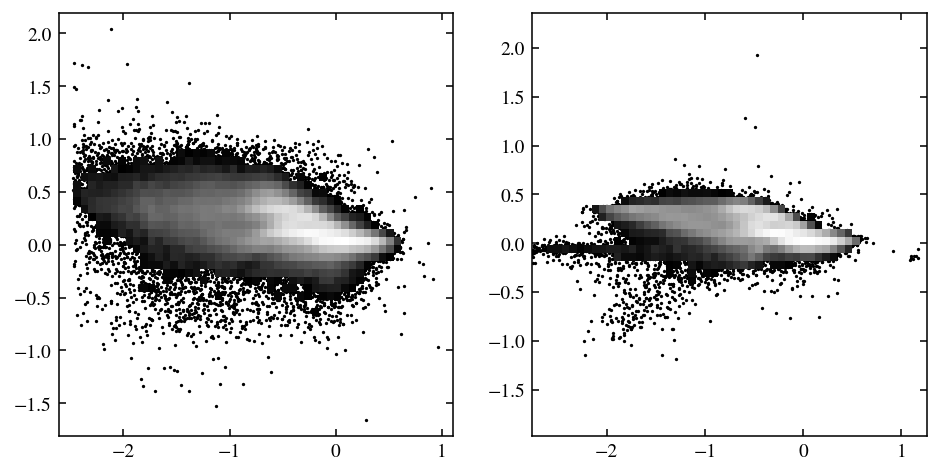

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
scatter_hist(axs[0], data['FE_H'], data['O_FE'])
scatter_hist(axs[1], data['ASTRONN_FE_H'], data['ASTRONN_O_FE'], xlim=axs[0].get_xlim(), ylim=axs[0].get_ylim())
# axs[1].set_xlim(axs[0].get_xlim())
# axs[1].set_ylim(axs[0].get_ylim())
plt.show()

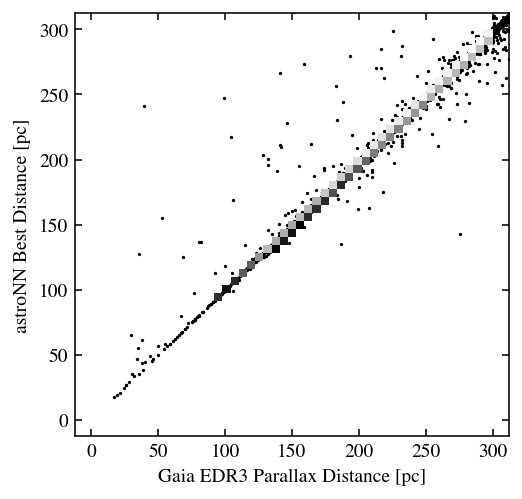

In [43]:
fig, ax = plt.subplots()
scatter_hist(ax, 1 / (data['GAIAEDR3_PARALLAX'] * 1e-3), data['ASTRONN_DIST'], xlim=(0, 300), ylim=(0, 300))
ax.set_xlabel('Gaia EDR3 Parallax Distance [pc]')
ax.set_ylabel('astroNN Best Distance [pc]')
plt.show()

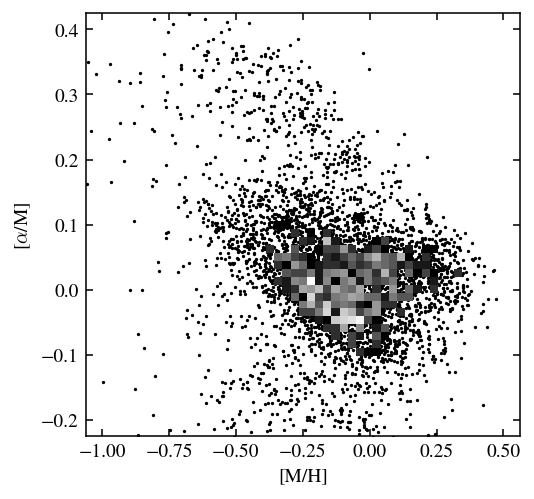

In [44]:
local = data[data['GAIAEDR3_PARALLAX'] > (1/300 * 1e3)]
fig, ax = plt.subplots()
scatter_hist(ax, local['FE_H'], local['MG_FE'], xlim=(-1, 0.5), ylim=(-0.2, 0.4))
ax.set_xlabel('[M/H]')
ax.set_ylabel(r'[$\alpha$/M]')
plt.show()

In [49]:
data['ASTRONN_MG_FE'] = data['ASTRONN_MG_H'] - data['ASTRONN_FE_H']
data['ASTRONN_MG_FE_ERR'] = quad_add(data['ASTRONN_MG_H_ERR'], data['ASTRONN_FE_H_ERR'])

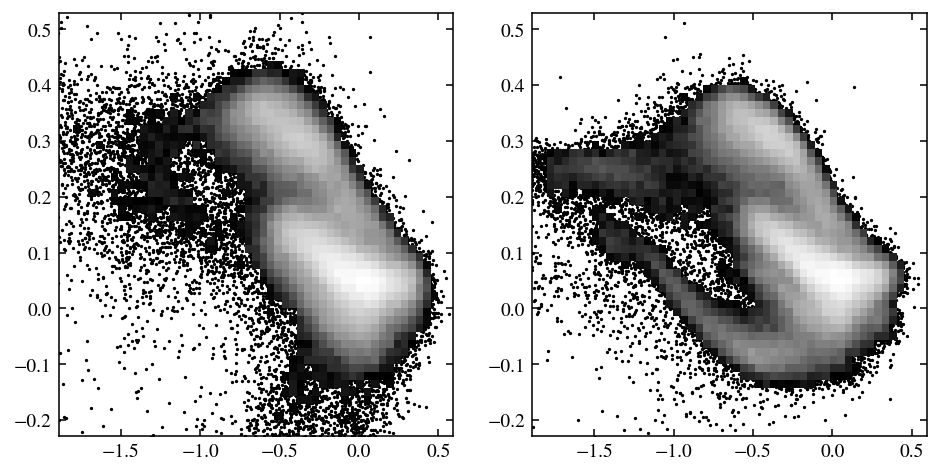

In [56]:
local = data[(data['ASTRONN_GALR'] >= 7) & (data['ASTRONN_GALR'] < 9)]
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
scatter_hist(axs[0], local['FE_H'], local['MG_FE'], xlim=(-1.8, 0.5), ylim=(-0.2, 0.5))
scatter_hist(axs[1], local['ASTRONN_FE_H'], local['ASTRONN_MG_FE'], xlim=(-1.8, 0.5), ylim=(-0.2, 0.5))
plt.show()

The region of [Fe/H] in (-1, 0.6) and [Mg/Fe] in (0.1, 0.3) is the low-Fe tail of the low-alpha distribution in the Santos-Peral et al. (2021) data set - so why is that region so conspicuously empty in the APOGEE data above?

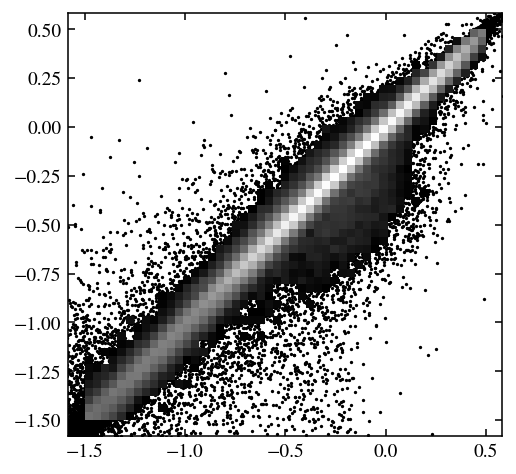

In [55]:
fig, ax = plt.subplots()
scatter_hist(ax, data['FE_H'], data['ASTRONN_FE_H'], xlim=(-1.5, 0.5), ylim=(-1.5, 0.5))
plt.show()

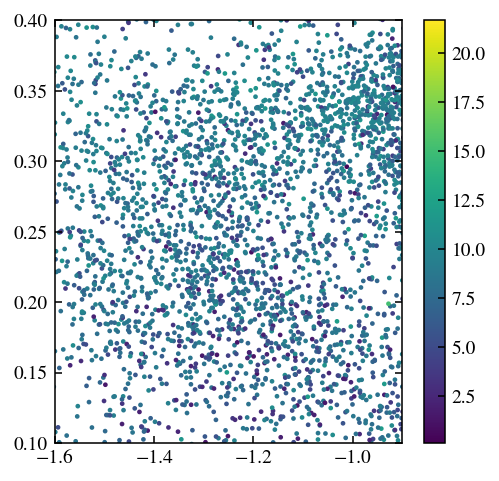

In [66]:
fig, ax = plt.subplots()
pc = ax.scatter(local['FE_H'], local['MG_FE'], s=2, c=local['ASTRONN_AGE'])
plt.colorbar(pc)
ax.set_xlim(-1.6, -0.9)
ax.set_ylim(0.1, 0.4)
plt.show()